In [162]:
import torch
import torch.nn as nn
from torchsummary import summary
from torch.optim import Adam, lr_scheduler
from torchvision import models, transforms as transforms, datasets
from torch.utils.data import Dataset, random_split, DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
from pytorch_lightning import LightningDataModule, LightningModule
import pytorch_lightning as pl
from glob import glob
from torch_snippets import * 
from ultralytics import YOLO 
from pytorch_lightning.callbacks.progress import TQDMProgressBar
#YOLO model
model = YOLO("yolo11n.pt")

# Train Images
f = r"/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/train/images/*"
ims = glob(f"{f}/*")

#Classes
cls_dir = r'/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/classes.txt'
with open(cls_dir, 'r') as c:
    classes = c.readlines()
classes = classes[0].split(' ')
classes = classes[:-1]
label2target = {l:t+1 for t, l in enumerate(classes)}
label2target["UnIdentified person"] = 0
target2label = {t:l for l, t in label2target.items()}

# Sample Image (Change later for prediction)
img = read(ims[-1])
#Resize Image sample
img_resized = resize(img, (640, 640))
#YOLO Prediction
pred = model(img_resized)[0]
#Bollean for person prediction in yolo
is_person_detected = any(box.cls == 0 for box in pred.boxes)
print("person? ",is_person_detected)

person_bbs = pred.boxes.xyxy
x = person_bbs.tolist()
x = [list(map(int, i)) for i in x]
#real_bbs_person = [x[1]]

ims = []
for k in range(len(x)):
    ims.append(img_resized[x[k][1]:x[k][3],x[k][0]:x[k][2]])

#Use for Image classification
im = [j for i,j in enumerate(ims)]
#show(img_resized, bbs = x)


0: 640x640 1 person, 1 laptop, 904.6ms
Speed: 9.9ms preprocess, 904.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
person?  True


In [13]:
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torchvision import models, transforms as T
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from glob import glob
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from ultralytics import YOLO
from torch_snippets import *
from torchsummary import summary
from pytorch_lightning.callbacks.progress import TQDMProgressBar

model = YOLO("yolo11n.pt")

f = r"/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/train/images/*"
ims = glob(f"{f}/*")

cls_dir = r'/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/classes.txt'
with open(cls_dir, 'r') as c:
    classes = c.readlines()
classes = classes[0].split(' ')
classes = classes[:-1]
label2target = {l:t+1 for t, l in enumerate(classes)}
label2target["UnIdentified person"] = 0
target2label = {t:l for l, t in label2target.items()}

img = read(ims[-1])
img_resized = resize(img, (640, 640))

pred = model(img_resized)[0]

is_person_detected = any(box.cls == 0 for box in pred.boxes)
print("Person detected? ", is_person_detected)

person_bbs = pred.boxes.xyxy
x = person_bbs.tolist()
x = [list(map(int, i)) for i in x]

ims = []
for k in range(len(x)):
    ims.append(img_resized[x[k][1]:x[k][3], x[k][0]:x[k][2]])

im = [j for i,j in enumerate(ims)]

classes_path = r'/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/classes.txt'
with open(classes_path, "r") as F:
    classes = F.readlines()

train_tr = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_tr = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor()
])

df = pd.read_csv("charmae_only.csv")
img_dir = r'/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/train/images/train'
classes = [i[:-1] for i in classes]

class Data(Dataset):
    def __init__(self, dir, df, transform=None):
        self.dir = dir
        self.df = df
        self.transform = transform

        self.label2target = {label: idx for idx, label in enumerate(df['LabelName'].unique())}
        self.target2label = {idx: label for label, idx in self.label2target.items()}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        lbl = self.df['LabelName'][ix]
        target = self.label2target[lbl]

        im = self.df['images'][ix]
        img_path = f"{self.dir}/{im}"
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, target

    def collate_fn(self, batch):
        img, lbl = tuple(zip(*batch))
        img = torch.stack(img)
        lbl = torch.tensor(lbl, dtype=torch.long)
        return img, lbl

class DataModel(LightningDataModule):
    def __init__(self, df=df, img_dir=img_dir, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.df = df
        self.img_dir = img_dir  

        self.train_tr = T.Compose([
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        self.test_tr = T.Compose([
            T.Resize(224),
            T.CenterCrop(224),
            T.ToTensor()
        ])

    def setup(self, stage=None):
        train_df, test_df = train_test_split(self.df, test_size=0.2, random_state=99)
        train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=99)
        self.train_df = train_df.reset_index(drop=True)
        self.test_df = test_df.reset_index(drop=True)
        self.val_df = val_df.reset_index(drop=True)

    def train_dataloader(self):
        train_data = Data(self.img_dir, self.train_df, transform=self.train_tr)
        return DataLoader(train_data, batch_size=self.batch_size, shuffle=True, collate_fn=train_data.collate_fn)

    def test_dataloader(self):
        test_data = Data(self.img_dir, self.test_df, transform=self.test_tr)
        return DataLoader(test_data, batch_size=self.batch_size, shuffle=False, collate_fn=test_data.collate_fn)
    
    def val_dataloader(self):
        val_data = Data(self.img_dir, self.val_df, transform=self.test_tr)
        return DataLoader(val_data, batch_size=self.batch_size, shuffle=False, collate_fn=val_data.collate_fn)

class ModelLightningModule(LightningModule):
    def __init__(self, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        self.model = models.resnet50(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)

        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        imgs, lbls = batch
        logits = self(imgs)
        loss = self.loss_fn(logits, lbls.long())
        acc = (logits.argmax(1) == lbls).float().mean()
        self.log('train_loss', loss)
        self.log('train_acc', acc)
        return loss

    def validation_step(self, batch, batch_idx):
        imgs, lbls = batch
        logits = self(imgs)
        val_loss = self.loss_fn(logits, lbls.long())
        acc = (logits.argmax(1) == lbls).float().mean()
        self.log('val_loss', val_loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        imgs, lbls = batch
        logits = self(imgs)
        val_loss = self.loss_fn(logits, lbls.long())
        acc = (logits.argmax(1) == lbls).float().mean()
        self.log('val_loss', val_loss)
        self.log('val_acc', acc)

    
    def configure_optimizers(self):
        optimizer = Adam(self.parameters(), lr=1e-3)
        scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
        return [optimizer], [scheduler]

    def on_validation_epoch_end(self):
        avg_val_loss = self.trainer.callback_metrics['val_loss']
        avg_val_acc = self.trainer.callback_metrics['val_acc']
        self.log('val_loss', avg_val_loss, prog_bar=True)
        self.log('val_acc', avg_val_acc, prog_bar=True)


if __name__ == "__main__":
    data_module = DataModel(batch_size=32)
    model = ModelLightningModule()
    trainer = Trainer(
        max_epochs=10,
        callbacks=[TQDMProgressBar()],
        log_every_n_steps=10
    )
    trainer.fit(model, data_module)
    torch.save(model.state_dict(), 'model.pth')
    print(trainer.callback_metrics)
    trainer.test(model, data_module)


0: 640x640 1 person, 1 laptop, 405.2ms
Speed: 5.5ms preprocess, 405.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Person detected?  True


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | ResNet           | 23.5 M | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
2.0 K     Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.040    Total estimated model params size (MB)
152       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/zkllmt/anaconda3/envs/ForAI_Kernel/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


/home/zkllmt/anaconda3/envs/ForAI_Kernel/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Epoch 0:  20%|██        | 2/10 [00:22<01:28,  0.09it/s, v_num=13]

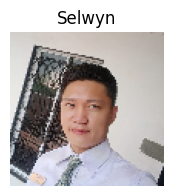

In [1]:
from torch_snippets import *
import face_recognition

def encode_face(img_path):
    """Encodes a face from an image file path."""
    img = face_recognition.load_image_file(img_path)
    encodings = face_recognition.face_encodings(img)
    if len(encodings) > 0:
        return encodings[0]  
    else:
        raise ValueError(f"No face detected in {img_path}")

def compare(face_encoding1, face_encoding2, tolerance=0.4):
    """Compares two face encodings with a specified tolerance."""
    return face_recognition.compare_faces([face_encoding1], face_encoding2, tolerance=tolerance)[0]
  
im1 = r"/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/train/images/train/eK3MiIuz.jpeg"
im2 = r"/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/train/images/train/yzT-J9oK.jpeg"
im11 = r"/home/zkllmt/Documents/AI Section/Datasets/Facial_Recognition_Custom_Dataset/test/images/person2/Selwyn.jpg"

try:
    imz = encode_face(im1)
    imz2 = encode_face(im2)
    imzz = encode_face(im11)
except ValueError as e:
    print(e)
    exit()

ims = [im1, im2, im11]
encodeds = [imz, imz2, imzz]
names = ["charmae", "charmae", "Selwyn"]



for ix, encoded_face in enumerate(encodeds):
    if compare(encoded_face, encodeds[-1]):
        show(resize(read(ims[ix]), (100, 100)), title=names[ix])